# Hasse Search Space Estimation

## Load Data

In [1]:
import json
import numpy as np
from os import listdir
from pprint import pprint
from statistics import mean, stdev
from typing import List, Dict

In [2]:
%pip install matplotlib
import matplotlib.pyplot as plt

You should consider upgrading via the '/Users/christophstein/Documents/jku/hasse_search_spaces/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load data

def get_file_paths(dir_path: str = "results") -> List[str]:
    file_names = listdir(dir_path)
    file_names = [file_name for file_name in file_names if file_name.endswith(".json")]

    file_paths = [
        f"{dir_path}/{file_name}"  for file_name in file_names
    ]
    return file_paths


def load_data(file_path: str) -> Dict:
    with open(file_path, "r") as data_file:
        return json.load(data_file)

experiment_paths = get_file_paths()
experiments = [
    load_data(file_path) for file_path in experiment_paths
]

print(f"Experiment count: {len(experiments)}")
print(experiments[0])

Experiment count: 27
{'meta': {'start': '2025-11-16 07:51:27.319064', 'end': '2025-11-16 16:12:08.575207'}, 'config': {'gate_set': '[H, S, T, CX]', 'gate_count': 35, 'qubit_num': 4, 'sample_num': 100000, 'seed_num': 30}, 'results': {'simulation_times': [53.608811, 53.971584, 53.693314, 54.40782, 53.182916, 54.12788, 53.772564, 53.973072, 53.936768, 54.771753, 53.802609, 54.112466, 54.077238, 54.575409, 54.381461, 53.907971, 53.973521, 54.154559, 53.960177, 53.737324, 53.999833, 54.081585, 54.572256, 53.948871, 53.921729, 54.735161, 54.302086, 54.052791, 54.100851, 54.434401], 'mean_simulation_time': 54.075959366666666, 'hasse_duplicate_counts': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'mean_hasse_duplicate_count': 0, 'hasse_encoding_times': [940.251004, 939.274439, 935.40008, 938.69642, 940.422209, 937.864021, 942.412075, 938.932947, 940.560936, 939.656212, 937.815444, 940.72395, 941.444497, 941.917464, 936.0319, 939.363178, 940.821369

In [4]:
# Filter experiments

def filter_experiments(experiments: List[Dict], target_qubit_nums: List[int] = None, target_gate_counts: List[int] = None, sort_by: str = "qubit_num") -> List:
    assert target_qubit_nums is not None or target_gate_counts is not None

    filtered_experiments = []
    for experiment in experiments:

        if target_qubit_nums is None:
            if experiment["config"]["gate_count"] in target_gate_counts:
                filtered_experiments.append(experiment)
        elif target_gate_counts is None:
            if experiment["config"]["qubit_num"] in target_qubit_nums:
                filtered_experiments.append(experiment)
        elif experiment["config"]["gate_count"] in target_gate_counts and experiment["config"]["qubit_num"] in target_qubit_nums: 
            filtered_experiments.append(experiment)

    filtered_experiments.sort(key=lambda item: item["config"][sort_by])
    return filtered_experiments

## Compute Search Space Size

In [5]:
def calculate_list_search_space_size(qubit_num: int, gate_count: int) -> int:
    # assuming Clifford+T gate set 

    return (qubit_num * (qubit_num - 1) + 3 * qubit_num) ** gate_count

In [6]:
# Calculate search space size

def calculate_expected_duplicates(size: int, sample_num: int) -> int:
    expected_duplicates = sample_num - size + size * (1 - 1/size) ** sample_num
    return expected_duplicates

def estimate_search_space_size(sample_num: int, actual_duplicates: int, lower_bound: int, upper_bound: int) -> int:
    if actual_duplicates == 0:
        return upper_bound

    # Expected number of duplicates decreases monotonically as search space increases

    search_range = (lower_bound, upper_bound)
    search_post_count = 3

    while True:

        # cut search interval into bins and evaluate
        search_posts = [
            i * (search_range[1] - search_range[0]) / (search_post_count - 1) + search_range[0] for i in range(search_post_count)
        ]
        search_posts = [int(search_post) for search_post in search_posts]

        smallest_delta = np.inf
        best_i = -1

        for search_post_i, search_post in enumerate(search_posts):
            estimated_duplicates = calculate_expected_duplicates(
                search_post, sample_num)
            delta = abs(estimated_duplicates - actual_duplicates)

            if delta < smallest_delta:
                smallest_delta = delta
                best_i = search_post_i

        if smallest_delta <= 1:
            return search_posts[best_i]

        try:
            if calculate_expected_duplicates(search_posts[best_i], sample_num) > actual_duplicates:
                search_range = (search_posts[best_i], search_posts[best_i + 1])
            else:
                search_range = (search_posts[best_i - 1], search_posts[best_i])
        except IndexError:
            print("Returning because of index error")
            return search_posts[best_i]

    return search_posts[best_i]


{'gate_set': '[H, S, T, CX]', 'gate_count': 5, 'qubit_num': 3, 'sample_num': 100000, 'seed_num': 30}
[9588, 9482, 9606, 9460, 9485, 9476, 9329, 9442, 9524, 9431, 9240, 9299, 9370, 9412, 9393, 9555, 9510, 9314, 9283, 9297, 9402, 9469, 9466, 9425, 9532, 9293, 9426, 9366, 9308, 9501]
Estimates: [487587, 493380, 486660, 494655, 493264, 493728, 502071, 495698, 491063, 496277, 507284, 503809, 499753, 497320, 498479, 489441, 491874, 502998, 504736, 503925, 497899, 494191, 494307, 496625, 490599, 504157, 496509, 499985, 503346, 492337]
Mean estimate: 496741
Actual: 759375

{'gate_set': '[H, S, T, CX]', 'gate_count': 5, 'qubit_num': 4, 'sample_num': 100000, 'seed_num': 30}
[1869, 1896, 1884, 1791, 1876, 1805, 1795, 1835, 1842, 1896, 1884, 1869, 1866, 1855, 1982, 1900, 1871, 1942, 1864, 1856, 1863, 1862, 1883, 1838, 1881, 1833, 1851, 1927, 1871, 1878]
Estimates: [2641410, 2604960, 2619540, 2758050, 2631690, 2736180, 2750760, 2692440, 2680290, 2604960, 2619540, 2641410, 2646270, 2663280, 2488320

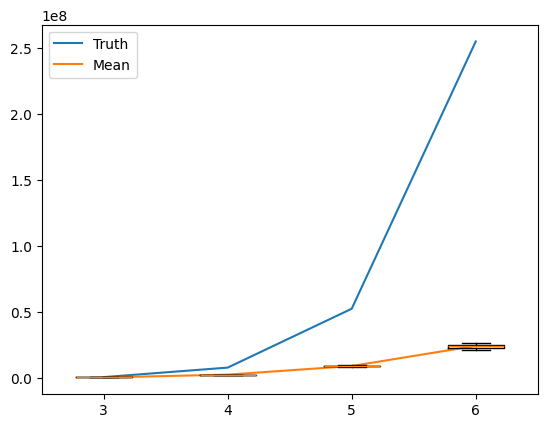

In [7]:
filtered_experiments = filter_experiments(experiments, target_gate_counts=[5])

qubit_nums = []
total_estimates: List[List] = []
total_actual_values: List = []
total_mean_estimates: List = []

for experiment in filtered_experiments:
    print("")
    print(experiment["config"])
    print(experiment["results"]["list_duplicate_counts"])

    qubit_nums.append(experiment["config"]["qubit_num"])

    actual = calculate_list_search_space_size(
        experiment["config"]["qubit_num"], experiment["config"]["gate_count"])
    total_actual_values.append(actual)

    estimates = [
        estimate_search_space_size(
            experiment["config"]["sample_num"], duplicate_count, lower_bound=1, upper_bound=actual * 5)
            for duplicate_count in experiment["results"]["list_duplicate_counts"]
    ]
    
    total_estimates.append(estimates)
    
    mean_estimate = estimate_search_space_size(
            experiment["config"]["sample_num"], experiment["results"]["mean_list_duplicate_count"], lower_bound=1, upper_bound=actual * 5)
    total_mean_estimates.append(mean_estimate)

    print(f"Estimates: {estimates}")
    print(f"Mean estimate: {mean_estimate}")
    print(f"Actual: {actual}")



fig, ax = plt.subplots()
ax.plot(qubit_nums, total_actual_values, label="Truth")
ax.plot(qubit_nums, total_mean_estimates, label="Mean")
ax.boxplot(total_estimates, positions=qubit_nums,
                showfliers=False,
                )

plt.legend()
plt.show()


## Search Space Hasse vs. List

In [8]:
gate_counts = [
    experiment["config"]["gate_count"] for experiment in experiments
]
gate_counts = list(set(gate_counts))
gate_counts.sort()

qubit_nums = [
    experiment["config"]["qubit_num"] for experiment in experiments
]
qubit_nums = list(set(qubit_nums))
qubit_nums.sort()


Search space sizes for 5 gates.


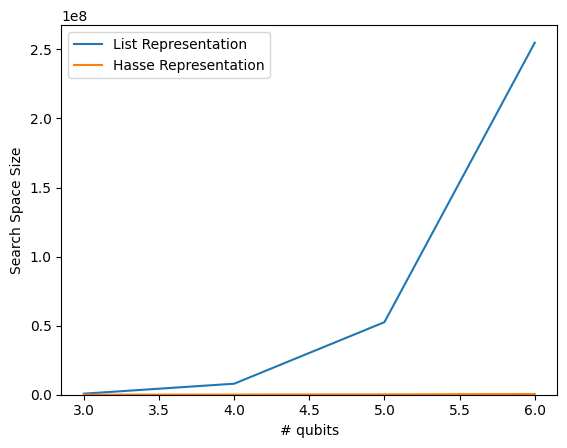

Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error

Search space sizes for 10 gates.


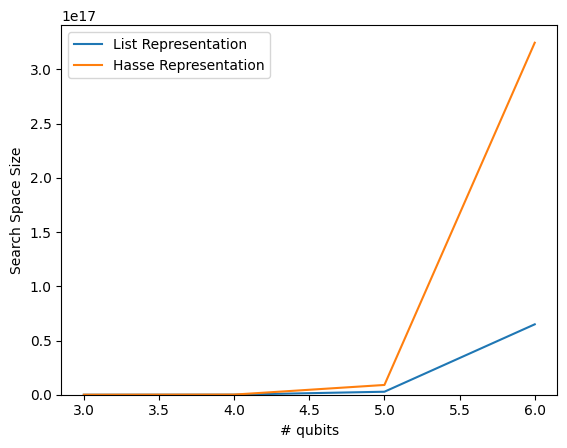

In [9]:
# accross gate counts

for gate_count in gate_counts:
    
    # TODO: Remove if new data becomes available
    if gate_count > 10:
        break

    filtered_experiments = filter_experiments(experiments, target_gate_counts=[gate_count])

    encountered_qubit_nums = []
    total_list_values = []
    total_hasse_estimates = []
    total_hasse_estimate_stdevs = []

    for experiment in filtered_experiments:
        encountered_qubit_nums.append(experiment["config"]["qubit_num"])

        actual_list_size = calculate_list_search_space_size(
            experiment["config"]["qubit_num"], experiment["config"]["gate_count"])
        total_list_values.append(actual_list_size)

        hasse_mean_estimate = estimate_search_space_size(
                experiment["config"]["sample_num"], experiment["results"]["mean_hasse_duplicate_count"], lower_bound=1, upper_bound=actual_list_size * 5)
        total_hasse_estimates.append(hasse_mean_estimate)

        hasse_estimates = [
            estimate_search_space_size(
                experiment["config"]["sample_num"], duplicate_count, lower_bound=1, upper_bound=actual * 5)
                for duplicate_count in experiment["results"]["hasse_duplicate_counts"]
        ]
        total_hasse_estimate_stdevs.append(stdev(hasse_estimates))

    print(f"\nSearch space sizes for {gate_count} gates.")
    ax = plt.subplot()

    ax.plot(encountered_qubit_nums, total_list_values, label="List Representation")
    
    ax.plot(encountered_qubit_nums, total_hasse_estimates, label="Hasse Representation")
    
    lower_bound_of_estimates = [
        estimate - estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    upper_bound_of_estimates = [
        estimate + estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    ax.fill_between(
        encountered_qubit_nums, lower_bound_of_estimates, upper_bound_of_estimates, alpha=0.3
    )

    ax.set_xlabel("# qubits")
    ax.set_ylabel("Search Space Size")
    ax.set_ylim(0)

    plt.legend()
    plt.show()



Search space sizes for 3 qubits.


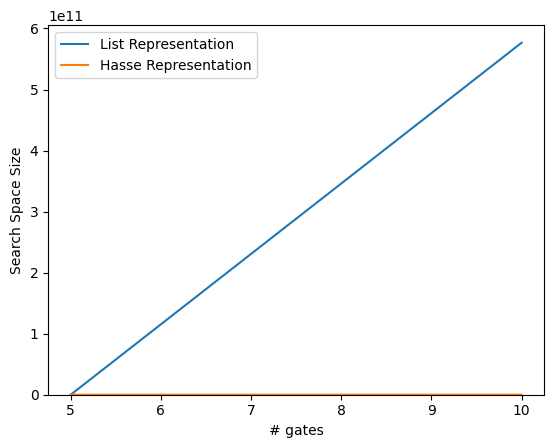


Search space sizes for 4 qubits.


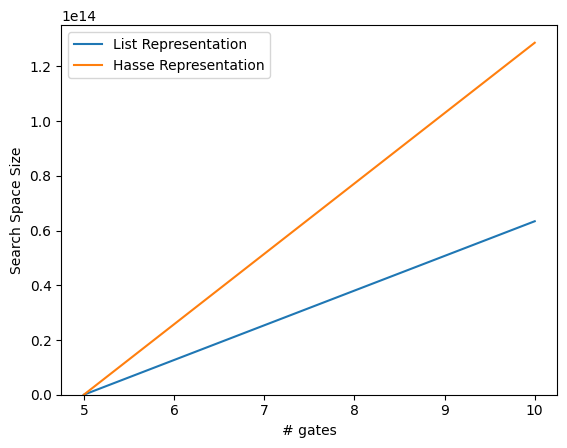

Returning because of index error
Returning because of index error

Search space sizes for 5 qubits.


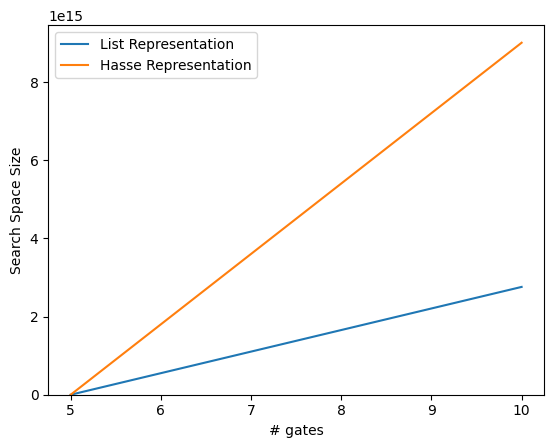

Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error
Returning because of index error

Search space sizes for 6 qubits.


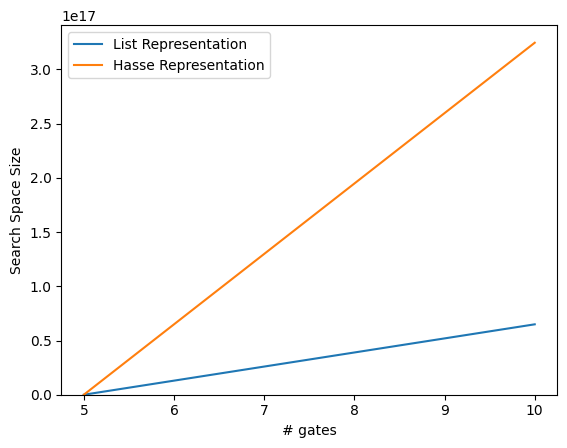

In [10]:
# accross qubit nums

for qubit_num in qubit_nums:
    
    # TODO: Remove if new data becomes available
    filtered_experiments = filter_experiments(experiments, target_qubit_nums=[qubit_num], target_gate_counts=[5, 10], sort_by="gate_count")

    encountered_gate_counts = []
    total_list_values = []
    total_hasse_estimates = []
    total_hasse_estimate_stdevs = []

    for experiment in filtered_experiments:
        encountered_gate_counts.append(experiment["config"]["gate_count"])

        actual_list_size = calculate_list_search_space_size(
            experiment["config"]["qubit_num"], experiment["config"]["gate_count"])
        total_list_values.append(actual_list_size)

        hasse_mean_estimate = estimate_search_space_size(
                experiment["config"]["sample_num"], experiment["results"]["mean_hasse_duplicate_count"], lower_bound=1, upper_bound=actual_list_size * 5)
        total_hasse_estimates.append(hasse_mean_estimate)

        hasse_estimates = [
            estimate_search_space_size(
                experiment["config"]["sample_num"], duplicate_count, lower_bound=1, upper_bound=actual * 5)
                for duplicate_count in experiment["results"]["hasse_duplicate_counts"]
        ]
        total_hasse_estimate_stdevs.append(stdev(hasse_estimates))

    print(f"\nSearch space sizes for {qubit_num} qubits.")
    ax = plt.subplot()

    ax.plot(encountered_gate_counts, total_list_values, label="List Representation")
    
    ax.plot(encountered_gate_counts, total_hasse_estimates, label="Hasse Representation")
    
    lower_bound_of_estimates = [
        estimate - estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    upper_bound_of_estimates = [
        estimate + estimate_stdev for estimate, estimate_stdev in zip(total_hasse_estimates, total_hasse_estimate_stdevs)
    ]
    ax.fill_between(
        encountered_gate_counts, lower_bound_of_estimates, upper_bound_of_estimates, alpha=0.3
    )

    ax.set_xlabel("# gates")
    ax.set_ylabel("Search Space Size")
    ax.set_ylim(0)

    plt.legend()
    plt.show()


## Computation time hasse vs. simulation time


Simulation time for 5 gates.


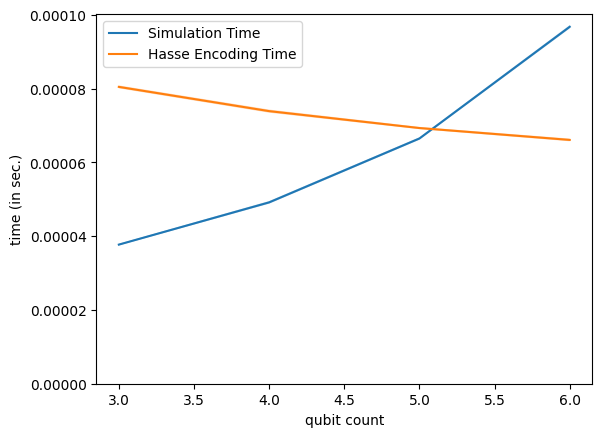


Simulation time for 10 gates.


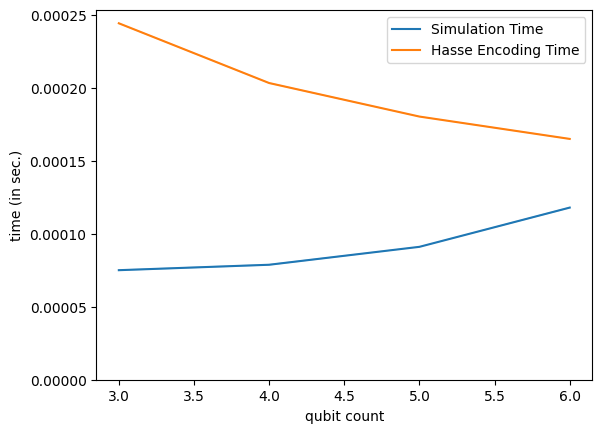


Simulation time for 15 gates.


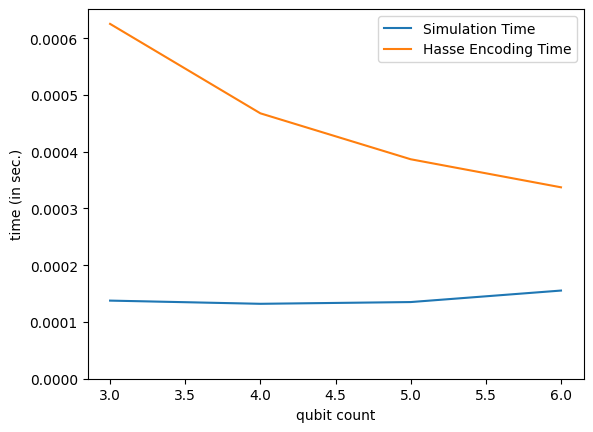


Simulation time for 20 gates.


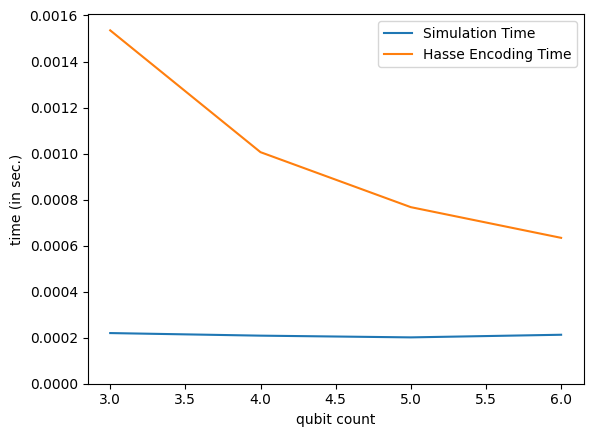


Simulation time for 25 gates.


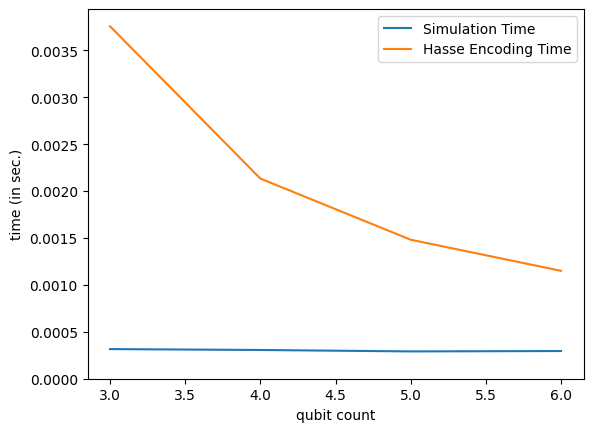


Simulation time for 30 gates.


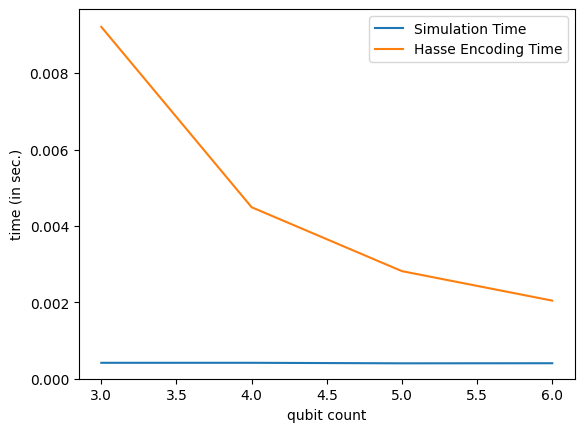


Simulation time for 35 gates.


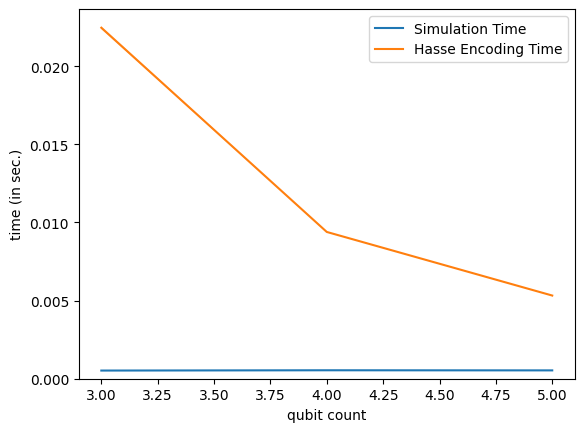

In [11]:
# accross gate counts

for gate_count in gate_counts:
    
    filtered_experiments = filter_experiments(experiments, target_gate_counts=[gate_count])

    encountered_qubit_nums = []
    total_simulation_times = []
    total_simulation_time_stdevs = []
    total_hasse_times = []
    total_hasse_time_stdevs = []

    for experiment in filtered_experiments:
        encountered_qubit_nums.append(experiment["config"]["qubit_num"])

        simulation_times_per_circuit = [
            time / experiment["config"]["sample_num"] for time in experiment["results"]["simulation_times"] 
        ]
        total_simulation_times.append(mean(simulation_times_per_circuit))
        total_simulation_time_stdevs.append(stdev(simulation_times_per_circuit))

        hasse_times_per_circuit = [
            time / experiment["config"]["sample_num"] for time in experiment["results"]["hasse_encoding_times"] 
        ]
        total_hasse_times.append(mean(hasse_times_per_circuit))
        total_hasse_time_stdevs.append(stdev(hasse_times_per_circuit))



    print(f"\nSimulation time for {gate_count} gates.")
    ax = plt.subplot()

    ax.plot(encountered_qubit_nums, total_simulation_times, label="Simulation Time")

    lower_bound_of_simulation_times = [
        time - time_stdev for time, time_stdev in zip(total_simulation_times, total_simulation_time_stdevs)
    ]
    upper_bound_of_simulation_times = [
        time + time_stdev for time, time_stdev in zip(total_simulation_times, total_simulation_time_stdevs)
    ]

    ax.fill_between(
        encountered_qubit_nums, lower_bound_of_simulation_times, upper_bound_of_simulation_times, alpha=0.3
    )


    ax.plot(encountered_qubit_nums, total_hasse_times, label="Hasse Encoding Time")
    
    lower_bound_of_hasse_times = [
        time - time_stdev for time, time_stdev in zip(total_hasse_times, total_hasse_time_stdevs)
    ]
    upper_bound_of_hasse_times = [
        time + time_stdev for time, time_stdev in zip(total_hasse_times, total_hasse_time_stdevs)
    ]
    ax.fill_between(
        encountered_qubit_nums, lower_bound_of_hasse_times, upper_bound_of_hasse_times, alpha=0.3
    )

    ax.set_xlabel("qubit count")
    ax.set_ylabel("time (in sec.)")
    ax.set_ylim(0)

    plt.legend()
    plt.show()



Simulation time for 3 qubits.


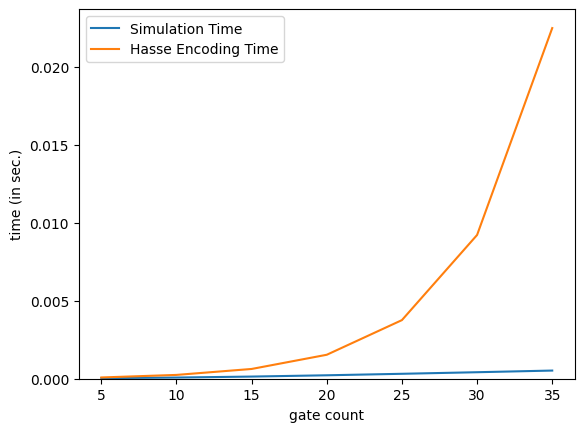


Simulation time for 4 qubits.


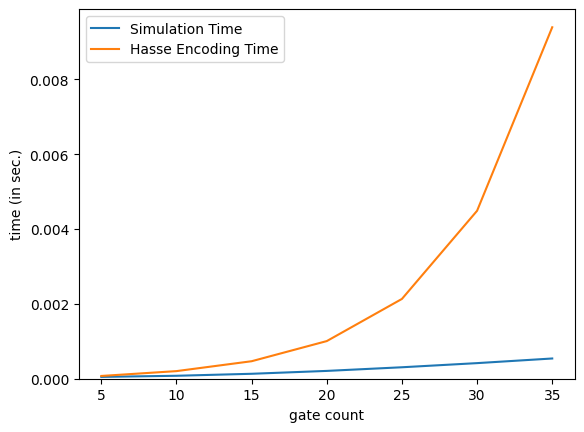


Simulation time for 5 qubits.


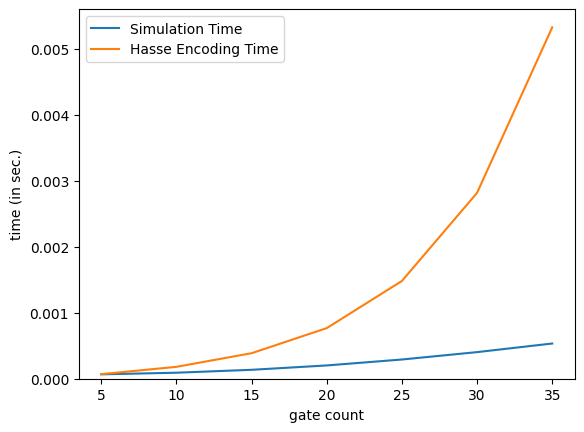


Simulation time for 6 qubits.


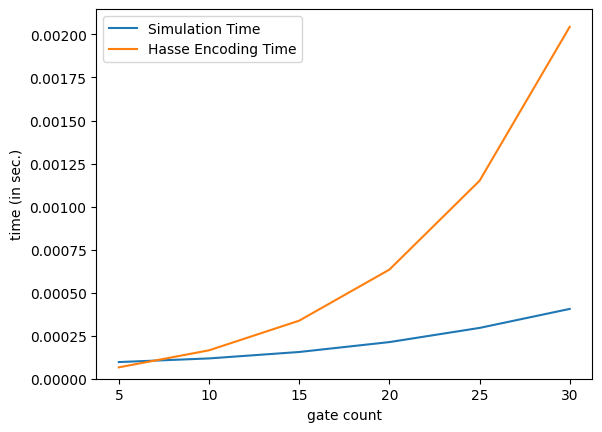

In [12]:
# accross qubit nums

for qubit_num in qubit_nums:
    filtered_experiments = filter_experiments(experiments, target_qubit_nums=[qubit_num], sort_by="gate_count")

    encountered_gate_counts = []
    total_simulation_times = []
    total_simulation_time_stdevs = []
    total_hasse_times = []
    total_hasse_time_stdevs = []

    for experiment in filtered_experiments:
        encountered_gate_counts.append(experiment["config"]["gate_count"])

        simulation_times_per_circuit = [
            time / experiment["config"]["sample_num"] for time in experiment["results"]["simulation_times"] 
        ]
        total_simulation_times.append(mean(simulation_times_per_circuit))
        total_simulation_time_stdevs.append(stdev(simulation_times_per_circuit))

        hasse_times_per_circuit = [
            time / experiment["config"]["sample_num"] for time in experiment["results"]["hasse_encoding_times"] 
        ]
        total_hasse_times.append(mean(hasse_times_per_circuit))
        total_hasse_time_stdevs.append(stdev(hasse_times_per_circuit))



    print(f"\nSimulation time for {qubit_num} qubits.")
    ax = plt.subplot()

    ax.plot(encountered_gate_counts, total_simulation_times, label="Simulation Time")

    lower_bound_of_simulation_times = [
        time - time_stdev for time, time_stdev in zip(total_simulation_times, total_simulation_time_stdevs)
    ]
    upper_bound_of_simulation_times = [
        time + time_stdev for time, time_stdev in zip(total_simulation_times, total_simulation_time_stdevs)
    ]

    ax.fill_between(
        encountered_gate_counts, lower_bound_of_simulation_times, upper_bound_of_simulation_times, alpha=0.3
    )


    ax.plot(encountered_gate_counts, total_hasse_times, label="Hasse Encoding Time")
    
    lower_bound_of_hasse_times = [
        time - time_stdev for time, time_stdev in zip(total_hasse_times, total_hasse_time_stdevs)
    ]
    upper_bound_of_hasse_times = [
        time + time_stdev for time, time_stdev in zip(total_hasse_times, total_hasse_time_stdevs)
    ]
    ax.fill_between(
        encountered_gate_counts, lower_bound_of_hasse_times, upper_bound_of_hasse_times, alpha=0.3
    )

    ax.set_xlabel("gate count")
    ax.set_ylabel("time (in sec.)")
    ax.set_ylim(0)

    plt.legend()
    plt.show()
